<a href="https://colab.research.google.com/github/ssakarin/lmembers/blob/main/L_members.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# 이거 실행(설치)하고 런타임 재시작 하면 한글 출력 가능
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (17.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf

from keras import layers
from keras import Sequential
from keras import optimizers
from keras.layers import Input, Dense, Flatten, Embedding

from keras.utils import plot_model
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# 한글 폰트 출력
plt.rc('font', family='NanumBarunGothic') 
# warning 무시
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/sample/lmemdata/'

In [ ]:
purchase_tr_path = '구매상품TR.txt'
merchant_cl_path = '상품분류.txt'
compet_use_path = '경쟁사이용.txt'
cust_demo_path = '고객DEMO.txt'
channel_use_path = '채널이용.txt'
membership_path = '멤버십여부.txt'

# 파일 불러오기

In [ ]:
df_membership = pd.read_csv(path+membership_path, encoding='cp949')   # 멤버쉽이 있는 회원은 기입됨
df_channel_use = pd.read_csv(path+channel_use_path, encoding='cp949') # 멤버들이 어떤 채널로 사용하는지
df_cust_demo = pd.read_csv(path+cust_demo_path, encoding='cp949') # 멤버들의 기본 신상 정보
df_compet_use = pd.read_csv(path+compet_use_path, encoding='cp949') # 멤버들이 경쟁 회사를 사용하는지
df_merchant_cl = pd.read_csv(path+merchant_cl_path, encoding='cp949') # 상품 정보

In [ ]:
# 대용량 데이터 불러오기 (transaction은 용량이 겁나 큼)
df_purchase_tr = pd.read_csv(path+purchase_tr_path, encoding='cp949', chunksize = 1000000) #100만개 단위로 끊기, 실제 transaction 데이터
chunk = list(df_purchase_tr)

print(len(chunk)) # 몇개 chunk인지 출력

df_purchase_tr = pd.concat(chunk)  # 데이터 넣기
df_purchase_tr.shape

29


(28593030, 10)

# 이용자 정보 합치기

- 고객 Demo, 멤버십 여부, 채널이용, 경쟁사 이용은 쉽게 합칠 수 있음


In [ ]:
print(df_cust_demo.columns)
print(df_membership.columns)
print(df_compet_use.columns)
print(df_channel_use.columns)

Index(['고객번호', '성별', '연령대', '거주지역'], dtype='object')
Index(['고객번호', '멤버십명', '가입년월'], dtype='object')
Index(['고객번호', '제휴사', '경쟁사', '이용년월'], dtype='object')
Index(['고객번호', '제휴사', '이용횟수'], dtype='object')


In [ ]:
#np.unique(pd.DataFrame(df_compet_use.groupby('고객번호')['경쟁사'].count())['경쟁사'], return_counts = True)
df_channel_use.제휴사.value_counts()

B_MOBILE/APP    5170
A_MOBILE/APP    1435
B_ONLINEMALL    1328
C_ONLINEMALL     618
D_MOBILE/APP     227
C_MOBILE/APP      46
Name: 제휴사, dtype: int64

## cust_demo  '고객DEMO.txt'

- 19383 명의 데이터
- '고객번호', '성별', '연령대', '거주지역' 정보를 담고 있음
- 고객번호, 성별, 연령대는 null값이 없음, 거주지역은 178개 null값 존재

## compet_use  '경쟁사이용.txt'

- A, B, C, D 4개의 제휴사에 대해서 각각 A1,A2 이런식으로 경쟁사가 존재(A -> B1 이런경우 없음)
- 경쟁사는 총 'A01', 'A02', 'B01', 'B02', 'C01', 'C02', 'C03', 'D01', 'D02' 9개 존재
- 5881명 / 19383 명의 고객이 경쟁사 이용한 적이 있음
- 응답한 사람들은 경쟁사 이용횟수가 1회~40회 사이로 응답

횟수 :
[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 40]


인원 :
[1749,  979,  611,  487,  371,  296,  222,  185,  145,  119,  106,
          87,   97,   61,   69,   47,   43,   36,   28,   25,   16,   17,
          20,   13,   10,    4,    7,    6,   10,    7,    2,    2,    3,
           1]


## channel_use  '채널이용.txt'

- 4개 계열사 관련 모바일/app(A.MOBILE/APP, B.MOBILE/APP, C.MOBILE/APP, D.MOBILE/APP)
- 2개 계열사 관련 온라인 쇼핑몰(B.ONLINEMALL, C.ONLINEMALL)
- 최근 3개월간 모바일/APP 로그인 횟수 , 최근 3개월간 온라인 쇼핑몰  구매 횟수

- 6766명/19383 이 모바일/온라인을 이용한 적이 있음

- B_MOBILE/APP    5170, A_MOBILE/APP    1435, C_MOBILE/APP      46, D_MOBILE/APP     227
- B_ONLINEMALL    1328, C_ONLINEMALL     618, 


## membership  '멤버십여부.txt'

- 하이마트, 다둥이, 더원, 롭스 멤버십 중에 하나 가입한 경우 표시
- 멤버십 가입 연월일 표시
- 하이마트    4418 ,다둥이     2009, 더영       642, 롭스       387
- 멤버쉽을 가지고 있는 회원 숫자 6498명/ 19383 (약 1/3 정도)
- 그중 5601이 한개의 멤버십만을 가지고 있음, 837 이 2개, 59명이 3개, 4개 다가지고 있는 사람은 1명

In [ ]:
df_members = pd.merge(df_cust_demo, df_membership, on='고객번호', how='outer')
df_members = pd.merge(df_members, df_compet_use, on='고객번호', how='outer')
df_members = pd.merge(df_members, df_channel_use, on='고객번호', how='outer') 
df_members.rename(columns = {'제휴사_x': '제휴사', '제휴사_y': '사용채널', '가입연월': '멤버쉽가입연월', '이용년월':'경쟁사이용년월' }, inplace = True)
df_members.drop(columns={'제휴사'}, inplace = True)  # 이 컬럼은 지워도 됨. 어짜피 경쟁사 COLUMN에 A,B,C,D중 하나 표시됨
df_members

,고객번호,성별,연령대,거주지역,멤버십명,가입년월,경쟁사,경쟁사이용년월,사용채널,이용횟수
0,1,M,60세이상,60.0,NaN,NaN,A01,201507.0,NaN,NaN
1,1,M,60세이상,60.0,NaN,NaN,A02,201504.0,NaN,NaN
2,1,M,60세이상,60.0,NaN,NaN,B01,201501.0,NaN,NaN
3,1,M,60세이상,60.0,NaN,NaN,B01,201502.0,NaN,NaN
4,1,M,60세이상,60.0,NaN,NaN,B01,201507.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
48842,19379,F,20세~24세,69.0,롭스,201412.0,NaN,NaN,NaN,NaN
48843,19380,F,20세~24세,39.0,롭스,201412.0,NaN,NaN,D_MOBILE/APP,1.0
48844,19381,F,40세~44세,460.0,다둥이,201506.0,NaN,NaN,B_MOBILE/APP,5.0
48845,19382,F,45세~49세,460.0,NaN,NaN,NaN,NaN,B_MOBILE/APP,9.0


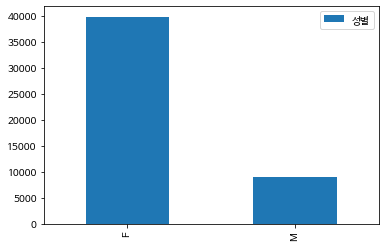

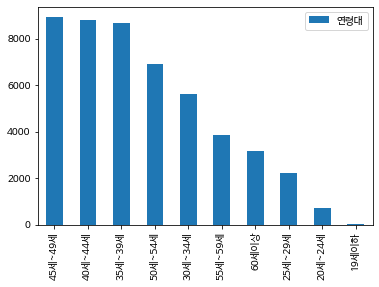

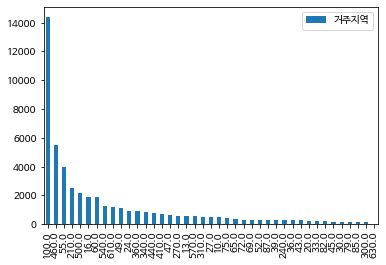

In [ ]:
# 간단히 분포 그려보기
pd.DataFrame(df_members.성별.value_counts()).plot(kind = 'bar'); # 여성이 많음
pd.DataFrame(df_members.연령대.value_counts()).plot(kind = 'bar'); # 연령 분포
pd.DataFrame(df_members.거주지역.value_counts()).plot(kind = 'bar');  # 지역코드가 숫자로 나옴
#pd.DataFrame(df_members.멤버십명	.value_counts()).plot(kind = 'bar'); # 멤버십은 4종류 (하이마트, 더영, 다동이, 롭스)
#pd.DataFrame(df_members.사용채널.value_counts()).plot(kind = 'bar'); 

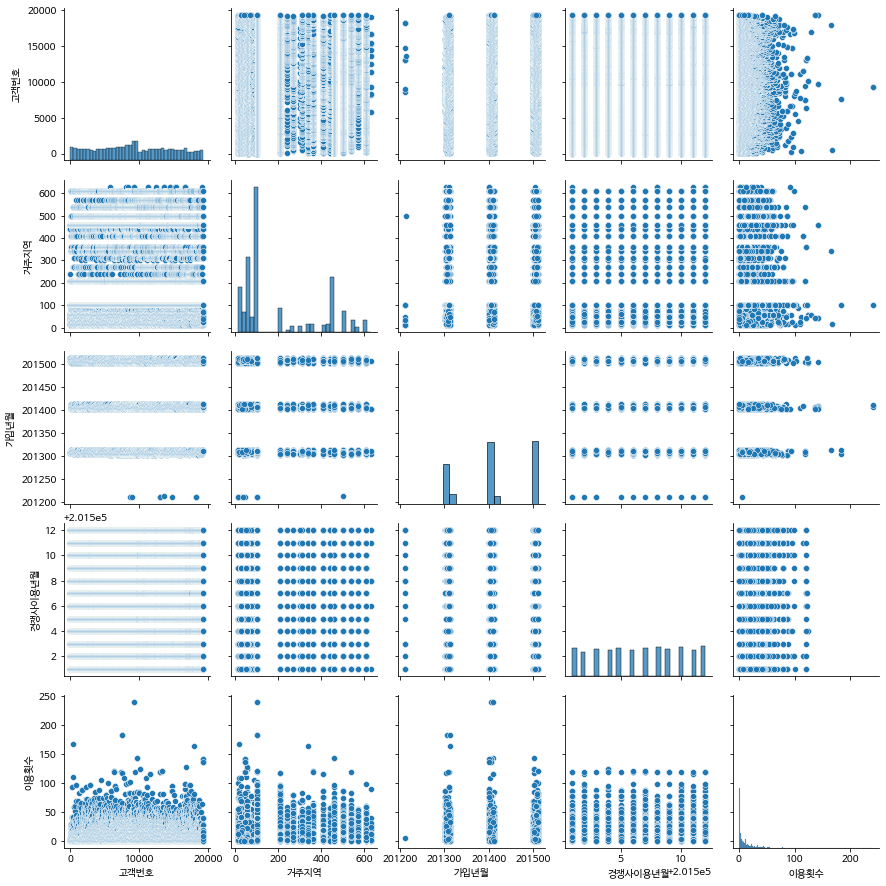

In [ ]:
# sns.jointplot(x= df_members.연령대, y = df_members.거주지역);
sns.pairplot(df_members);  # 데이터간 관계 그려보기

- 의미있어보이는 분포

> 고객번호-이용횟수 
> 고객번호-거주지역
> 거주지역-이용횟수
> 이용횟수 histogram

# 상품 분류 살펴보기

In [ ]:
print(df_merchant_cl.columns)

Index(['제휴사', '대분류코드', '중분류코드', '소분류코드', '중분류명', '소분류명'], dtype='object')


In [ ]:
df_merchant_cl

,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명
0,A,1,101,A010101,일용잡화,위생세제
1,A,1,101,A010102,일용잡화,휴지류
2,A,1,101,A010103,일용잡화,뷰티상품
3,A,1,101,A010104,일용잡화,일용잡화
4,A,1,101,A010105,일용잡화,세트상품
...,...,...,...,...,...,...
4381,D,8,802,D080204,아이메이크업,아이섀도우
4382,D,8,802,D080205,아이메이크업,메이크업세트
4383,D,8,803,D080301,립메이크업,립스틱/립라이너
4384,D,8,803,D080302,립메이크업,립글로즈/틴트


In [ ]:
# 제휴사는 4종류, 서로 분류가 완전히 다름
cat_a_df = df_merchant_cl[df_merchant_cl.제휴사 == 'A'] 
cat_b_df = df_merchant_cl[df_merchant_cl.제휴사 == 'B'] 
cat_c_df = df_merchant_cl[df_merchant_cl.제휴사 == 'C'] 
cat_d_df = df_merchant_cl[df_merchant_cl.제휴사 == 'D'] 

print('A 제휴사의 중분류: ',cat_a_df.중분류명.unique())  # 백화점?
print('\n')
print('B 제휴사의 중분류: ',cat_b_df.중분류명.unique())  # 롯데마트? 롯데슈퍼?
print('\n')
print('C 제휴사의 중분류: ',cat_c_df.중분류명.unique())  # 롯데마트? 롯데슈퍼?
print('\n')
print('D 제휴사의 중분류: ',cat_d_df.중분류명.unique())  # 롭스?

# print(cat_a_df.소분류명.unique())  # 백화점?
# print(cat_b_df.소분류명.unique())  # 롯데마트? 롯데슈퍼?
# print(cat_c_df.소분류명.unique())  # 롯데마트? 롯데슈퍼?
# print(cat_d_df.소분류명.unique())  # 롭스?

A 제휴사의 중분류:  ['일용잡화' '육류' '축산가공' '농산물' '수산품' '가공식품' '젓갈/반찬' '건강식품' '주류' '차/커피' '기타'
 '섬유잡화' '액세서리' '화장품' '보석' '준보석/시계' '피혁잡화' '구두' '아동' '캐주얼' '커리어' '트래디셔널'
 '시티웨어' '란제리/내의' '블라우스' '기타의류' '디자이너' '모피/피혁' '남성정장' '남성캐주얼' '교복' '셔츠'
 '남성 트랜디' '스포츠' '골프용품' '대형가전' '소형가전' '통신/컴퓨터' '악기' '전자/전기' '주방가전' '명품'
 '주방용품' '문구/팬시' '생활잡화' '식기' '가구' '침구/수예' '웨딩']


B 제휴사의 중분류:  ['열매채소' '버섯' '온라인버섯/열매채소' '조리반찬' '시즌반찬' '포장젓갈' '포장반찬' '양곡' '잡곡류' '즉석도정미'
 '가공양곡' '잎채소' '뿌리채소' '버섯류' '샐러드채소' '약초' '양념류' '식자재' '친환경채소' '김치채소'
 '온라인잎/샐러드채소' 'LOCAL잎채소' 'LOCAL김치채소' '샐러드/간편채소' '대중선어' '냉동수산물' '생선선물세트'
 '고등어/삼치' '대구' '도미/민어' '기타구색생선' '꽁치/가자미' '오징어' '조기/명태' '국산게/갈치' '선물세트'
 '즉석구이안주' '마른안주' '멸치건명태' '해조류' '특산물' '건오징어' '조미오징어' '육포' '쥐치포' '마른안주선물세트'
 'Fast Food' '편의시설' '레스토랑' '카페' '판매시설' '주유소' '브랜드조리' '베이커리' '구이' '튀김' '밥류'
 '구이찜조리' '반찬류' '대용식' '이벤트조리' '간식조리' '간편조리' '튀김조리' '피자' '냉장음료' '데일리처분'
 '흰우유' '가공우유' '요구르트' '유제품' '브랜드빵' '치즈' '디저트' '유가공' '조미료' '소스류' '장류' '식용유지'
 '조미선물세트' '가루' '향신료' '액상조미료' '복합조미료' '소금/설탕류' '수입조미' '간편조리식품' '

# 거래내역 살펴보기

In [ ]:
print(df_purchase_tr.columns)

Index(['제휴사', '영수증번호', '대분류코드', '중분류코드', '소분류코드', '고객번호', '점포코드', '구매일자',
       '구매시간', '구매금액'],
      dtype='object')


In [ ]:
df_purchase_tr.head(5)

,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,고객번호,점포코드,구매일자,구매시간,구매금액
0,B,8664000,15,1504,B150401,17218,44,20140222,20,2420
1,B,8664000,16,1601,B160101,17218,44,20140222,20,1070
2,B,8664000,16,1602,B160201,17218,44,20140222,20,8060
3,B,8664000,18,1803,B180301,17218,44,20140222,20,6000
4,B,8664001,5,509,B050901,17674,44,20140222,22,1120


In [ ]:
np.unique(df_purchase_tr.제휴사, return_counts = True)  # 제휴사별 구매 횟수

(array(['A', 'B', 'C', 'D'], dtype=object),
 array([ 5770318, 13338074,  9379236,   105402]))

In [ ]:
# 날짜별 구매금액
df_purchase_tr['구매일자'] = pd.to_datetime(df_purchase_tr['구매일자'],format='%Y%m%d')
sum_purchased = pd.DataFrame(df_purchase_tr.groupby('구매일자').구매금액.sum())
sum_purchased

,구매금액
구매일자,
2014-01-01,226382544
2014-01-02,949396728
2014-01-03,1622819431
2014-01-04,1130359567
2014-01-05,1078308138
...,...
2015-12-27,1218258711
2015-12-28,647580087
2015-12-29,670847320


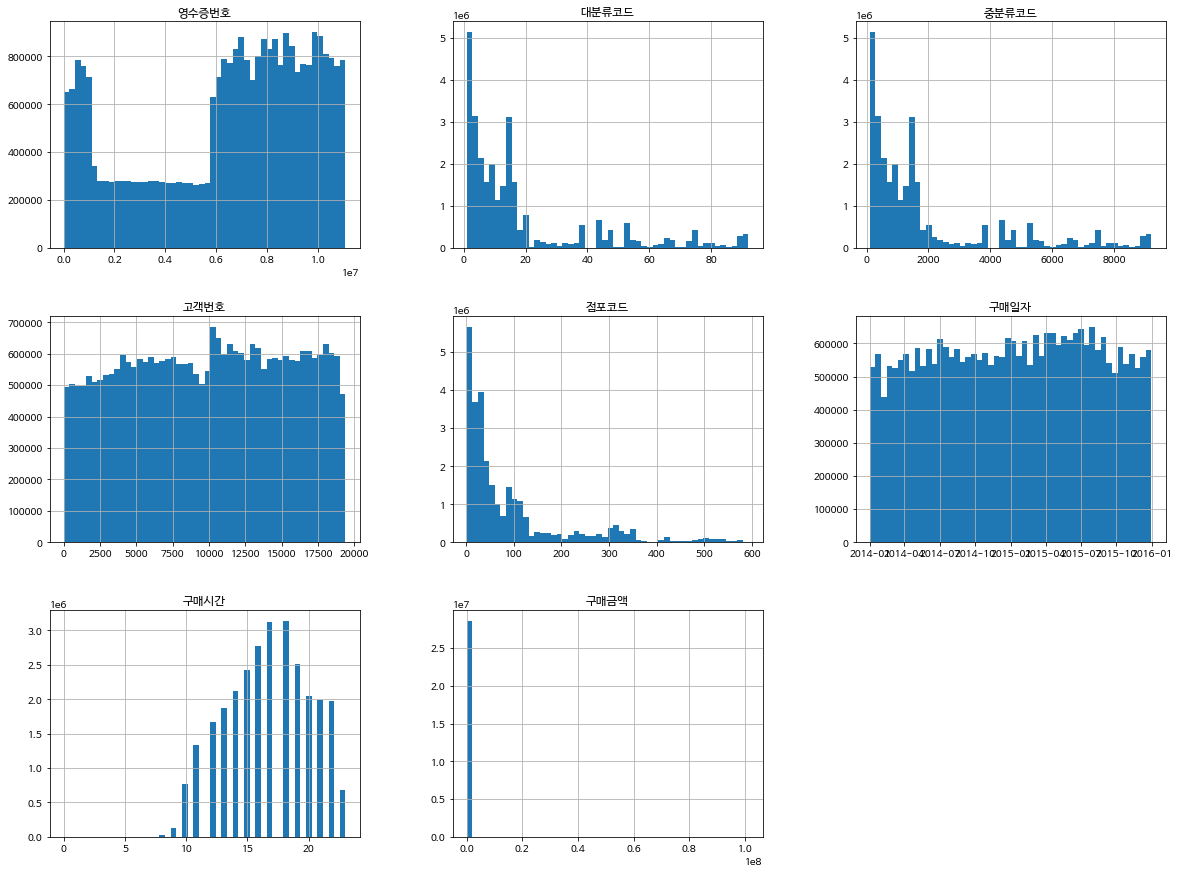

In [ ]:
df_purchase_tr.hist(bins=50, figsize=(20, 15));  # 데이터 분포 살펴보기

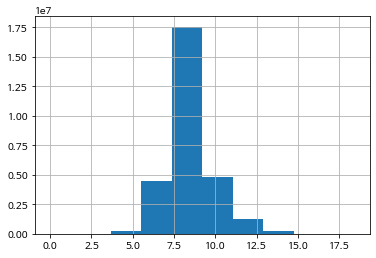

In [ ]:
#구매금액이 1원부터 1억원까지 너무 다양함, 소액은 많고 고액은 거의 없음, log 스케일로 표현하면 이런식
np.log(df_purchase_tr.구매금액).hist(); 

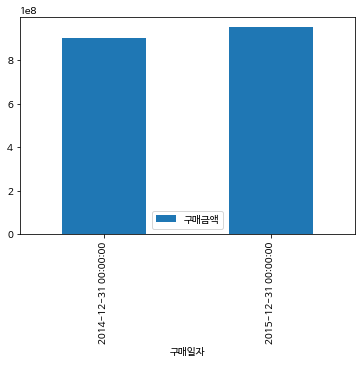

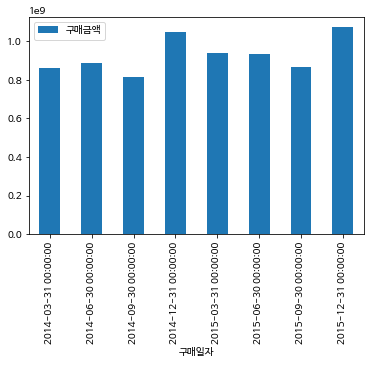

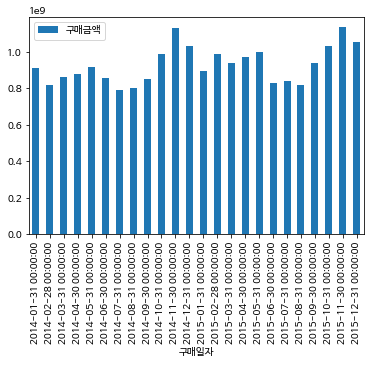

In [ ]:
# 연도, 분기, 월별 구매금액
sum_purchased.resample('Y').mean().plot(kind = 'bar');
sum_purchased.resample('Q').mean().plot(kind = 'bar');
sum_purchased.resample('M').mean().plot(kind = 'bar');

In [ ]:
# 고객별 구매금액
user_df = pd.DataFrame(df_purchase_tr.groupby(['고객번호','구매일자']).구매금액.sum())
user_df = user_df.swaplevel(0, 1, axis = 0)
user_df = user_df.unstack().resample('M').sum()   # 개별 고객의 월별 구매금액 합계
user_df =user_df['구매금액']   # column: 고객번호, row: 구매 월

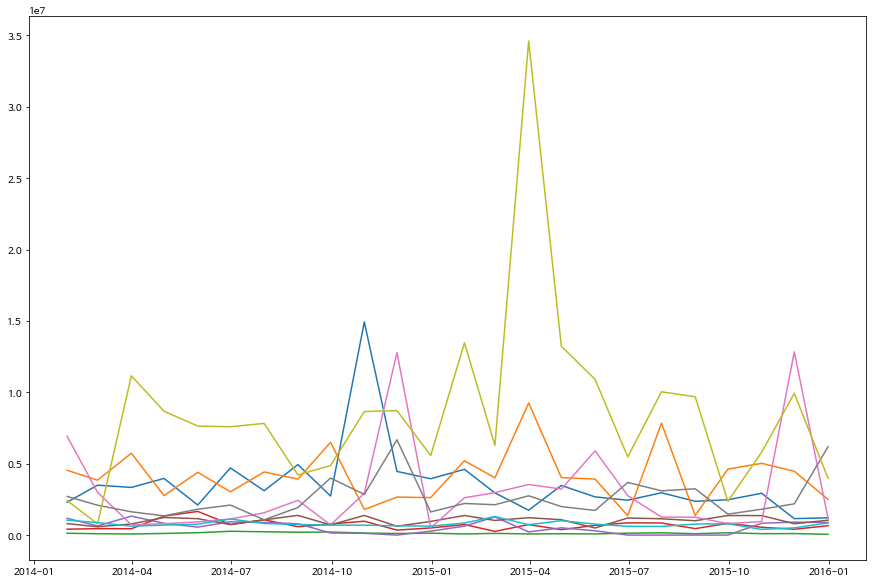

In [ ]:
# 1번 10번까지 고객의 월별 구매금액 합계 그래프
# 한번 그려보기
# 실제로는 전체 고객들 구매 동향 비율로 나누어줘야 할듯
# 이걸 연간/분기/월간 어떤걸로 나누어야 할지...
plt.figure(figsize = (15,10))
for i in range (10) :
  plt.plot(user_df[i+1]);

### 그래프용 함수들

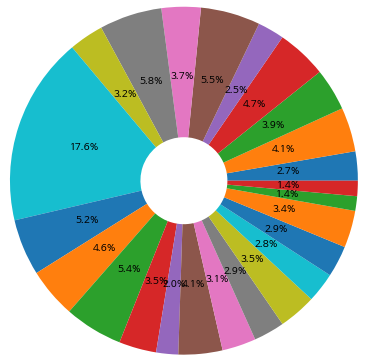

In [ ]:
# 1번 고객 매달 구매금액 파이차트
plt.pie(user_df[1], autopct='%.1f%%',labeldistance = 0.8, wedgeprops=dict(width=1.5), radius = 2);
#plt.legend(user_df[1].index, loc='best');

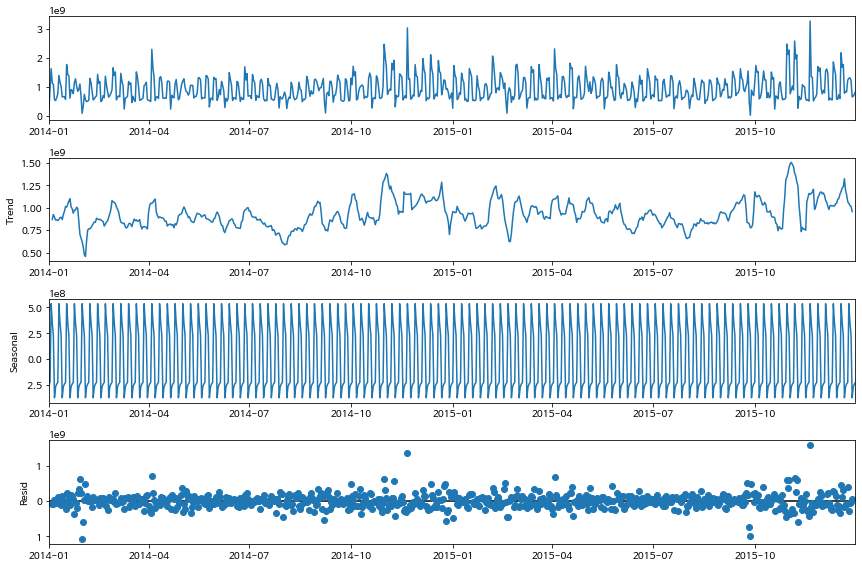

In [ ]:
# 구매금액 seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(sum_purchased, model='additive')
plt.rcParams['figure.figsize'] = [12, 8]
fig = result.plot()
plt.show()